# Real estate rental hedonic model workflow

Paul Waddell, July 2018

Python 3.6, intended to be backward compatible with 2.7

In [1]:
from __future__ import print_function
import warnings;warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import norm
%matplotlib inline

import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.mlab as mlab
import seaborn as sns
sns.set()

In [3]:
# Standard to run UrbanSim from the root level of the project directory

import os; os.chdir('../..')

In [4]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import OLSRegressionStep
import orca

In [13]:
# Load any script-based Orca registrations
from scripts import datasources
from scripts import models

In [6]:
import datashader as ds
import holoviews as hv
import geoviews as gv

In [7]:
ds.__version__

'0.6.6'

## Explore the Orca registrations

In [ ]:
orca.list_tables()

In [ ]:
for table_name in orca.list_tables():
    print(table_name.upper())
    print(orca.get_table(table_name).to_frame().columns.tolist())
    print()

In [ ]:
orca.list_broadcasts()

In [ ]:
orca.list_steps()

## Explore the data

Orca doesn't execute code to load the registered objects until it needs to.

In [ ]:
orca.get_table('parcels').to_frame().describe()

In [ ]:
buildings = orca.get_table('buildings').to_frame()
buildings.columns

In [ ]:
buildings.sqft_per_unit.describe()

In [ ]:
buildings.building_type_id.value_counts()

In [ ]:
buildings.residential_units.value_counts()

In [ ]:
households = orca.get_table('households').to_frame()
households.columns

In [ ]:
households.describe()

In [ ]:
households.race_of_head.value_counts()

In [ ]:
households.hispanic_head.value_counts()

In [ ]:
rentals = orca.get_table('craigslist').to_frame()
rentals.columns

In [ ]:
rentals.describe()

In [ ]:
rents_nodup = rentals.drop_duplicates(['pid'])
rents_nodup.describe()

In [ ]:
rents_nodup.rent.quantile([0.005, 0.995])

In [ ]:
rents_nodup.bedrooms.quantile([0.005, 0.995])

In [ ]:
rents_nodup.sqft.quantile([0.005, 0.995])

In [ ]:
rentlow = rents_nodup.rent.quantile(0.005)
renthigh = rents_nodup.rent.quantile(0.995)
bedshigh = rents_nodup.bedrooms.quantile(0.995)
sqftlow = rents_nodup.sqft.quantile(0.005)
sqfthigh = rents_nodup.sqft.quantile(0.995)

In [ ]:
rent_mask = (rents_nodup['rent'] > rentlow) & (rents_nodup['rent'] <= renthigh)
beds_mask = (rents_nodup['bedrooms'] <= bedshigh)
sqft_mask = (rents_nodup['sqft'] > sqftlow) & (rents_nodup['sqft'] <= sqfthigh)

# filter the thorough listings according to these masks
filtered_rents = pd.DataFrame(rents_nodup[rent_mask & beds_mask & sqft_mask])
len(filtered_rents)

In [ ]:
plt.rcParams['figure.figsize']=10,10
%matplotlib inline

sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(filtered_rents.rent, bins=50, fit=norm,  kde=False)

In [ ]:
plt.rcParams['figure.figsize']=10,10
%matplotlib inline

sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(np.log(filtered_rents.rent), bins=50, fit=norm, kde=False)

In [ ]:
filtered_rents.describe()

In [ ]:
filtered_rents.to_csv('data/rental_listings_cleaned.csv')

## Generate accessibility measures for the price model

The network accessibility metrics are not stored on disk; for now we'll generate them using legacy code.

In [8]:
orca.run(['initialize_network_small'])

INFO:orca.orca:start: run step 'initialize_network_small'


Running step 'initialize_network_small'


INFO:orca.orca:finish: run step 'initialize_network_small'


Time to execute step 'initialize_network_small': 31.88 s
Total time to execute iteration 1 with iteration value None: 31.88 s


In [9]:
orca.run(['initialize_network_walk'])

INFO:orca.orca:start: run step 'initialize_network_walk'


Running step 'initialize_network_walk'


INFO:orca.orca:finish: run step 'initialize_network_walk'


Time to execute step 'initialize_network_walk': 109.82 s
Total time to execute iteration 1 with iteration value None: 109.83 s


In [10]:
orca.broadcast('nodessmall', 'rentals', cast_index=True, onto_on='node_id_small')
orca.broadcast('nodeswalk', 'rentals', cast_index=True, onto_on='node_id_walk')

In [ ]:
orca.run(['network_aggregations_small'])

In [ ]:
orca.run(['network_aggregations_walk'])

In [ ]:
orca.list_tables()

In [14]:
nodessmall = orca.get_table('nodessmall').to_frame()

In [ ]:
nodessmall.to_csv('data/nodessmall_vars.csv')

In [ ]:
nodeswalk.to_csv('data/nodeswalk_vars.csv')

In [15]:
nodeswalk = orca.get_table('nodeswalk').to_frame()

In [ ]:
nodeswalk.head()

In [ ]:
rentals = orca.get_table('rentals').to_frame()

In [ ]:
rentals.head()

In [ ]:
rentals.node_id_drive.isnull().sum()

In [ ]:
print('{} nodes have median income zero or below'.format(len(nodessmall[nodessmall.med_income_10000 == -1])))

print('Total nodes count {}'.format(len (nodessmall)))

# Estimate a rental hedonic model

The basic idea of the parcel template is that we create model steps by _passing arguments to classes_ rather than by writing Python functions and giving them Orca decorators, as we would for a fully custom model.

Much of the functionality for this is already built into UrbanSim and Orca, we'll just need to extend things here and there.

This demo uses a new RegressionStep() class that provides a full model development workflow: estimating a model, registering it with Orca, saving it for future use.

### Specify parameters and pass them to a model object

In [16]:
m = OLSRegressionStep()
m.tables = ['rentals', 'nodessmall', 'nodeswalk']
m.filters = ['rent_sqft < 10']
m.model_expression = 'np.log1p(rent_sqft) ~ +  np.log(units_500_walk+1) + np.log(sqft_unit_500_walk+2)  + \
    np.log(rich_500_walk + 1) + np.log(singles_500_walk + 1) + np.log(elderly_hh_500_walk + 1) + \
    np.log(children_500_walk + 1) + \
    np.log(jobs_500_walk + 1) + np.log(jobs_1500_walk+1) + np.log(jobs_10000+1) + np.log(jobs_25000 + 1) + \
    np.log(pop_10000+1) + np.log(pop_black_10000+1) + np.log(pop_hisp_10000+1) + \
    np.log(pop_asian_10000+1)  '
m.name = 'hedonic_rent_sqft'
m.tags = ['paul', 'version 1']

m.fit()

                             OLS Regression Results                            
Dep. Variable:     np.log1p(rent_sqft)   R-squared:                       0.368
Model:                             OLS   Adj. R-squared:                  0.368
Method:                  Least Squares   F-statistic:                 1.507e+04
Date:                 Tue, 17 Jul 2018   Prob (F-statistic):               0.00
Time:                         14:38:26   Log-Likelihood:                 72328.
No. Observations:               362901   AIC:                        -1.446e+05
Df Residuals:                   362886   BIC:                        -1.445e+05
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


In [17]:
orca.list_tables()

['parcels',
 'buildings',
 'craigslist',
 'rentals',
 'nodessmall_vars',
 'nodeswalk_vars',
 'units',
 'households',
 'persons',
 'jobs',
 'nodessmall',
 'nodeswalk']

In [18]:
rentals = orca.get_table('rentals').to_frame()
rentals['predicted_ln_rent_sqft'] = 0.0
orca.add_table('rentals', rentals)
m.out_column = 'predicted_ln_rent_sqft'
m.run()

In [19]:
rentals['predicted_rent_sqft'] = np.exp(rentals['predicted_ln_rent_sqft']) - 1

In [20]:
rentals['residuals_rent_sqft'] = rentals.predicted_rent_sqft - rentals.rent_sqft

In [21]:
rentals.head()

Unnamed: 0             date      region  \
pid                                                   
5873885791           0  11/13/2016 0:00  sacramento   
5873796738           1  11/13/2016 0:00  sacramento   
5873897352           2  11/13/2016 0:00       sfbay   
5873905471           3  11/13/2016 0:00       sfbay   
5873905300           4  11/13/2016 0:00       sfbay   

                               neighborhood  rent  bedrooms  sqft  rent_sqft  \
pid                                                                            
5873885791                                   1717         2   943   1.820785   
5873796738                        Fairfield  1275         2   900   1.416667   
5873897352  dublin / pleasanton / livermore  2250         1   687   3.275109   
5873905471                     potrero hill  5180         2  1060   4.886792   
5873905300                      santa clara  2588         2  1070   2.418692   

             longitude   latitude         county    fips_block state  \
pid                                                                    
5873885791 -121.962386  38.357364         Solano  6.095250e+13    CA   
5873796738 -122.019980  38.262374         Solano  6.095250e+13    CA   
5873897352 -121.888125  37.708458        Alameda  6.001450e+13    CA   
5873905471 -122.403979  37.769428  San Francisco  6.075060e+13    CA   
5873905300 -121.959929  37.397865    Santa Clara  6.085500e+13    CA   

           bathrooms  node_id_small  node_id_walk  predicted_ln_rent_sqft  \
pid                                                                         
5873885791                 62413119      57938834                1.158671   
5873796738                 62388472      57793805                1.048572   
5873897352               3110365111    3110365111                1.357166   
5873905471               2304626340    3985226614                1.666896   
5873905300               1071836625    4106391993                1.434917   

            predicted_rent_sqft  residuals_rent_sqft  
pid                                                   
5873885791             2.185697             0.364912  
5873796738             1.853572             0.436906  
5873897352             2.885166            -0.389943  
5873905471             4.295704            -0.591088  
5873905300             3.199298             0.780607

In [22]:
rentals[['rent_sqft','predicted_rent_sqft','residuals_rent_sqft']].describe()

rent_sqft  predicted_rent_sqft  residuals_rent_sqft
count  363055.000000        363055.000000        363055.000000
mean        3.177249             3.090975            -0.086273
std         1.089517             0.599273             0.869731
min         0.283500             0.264084           -16.775023
25%         2.493750             2.681834            -0.489676
50%         2.998120             3.105568             0.011563
75%         3.675385             3.486385             0.439673
max        19.609375             4.959174             4.225275

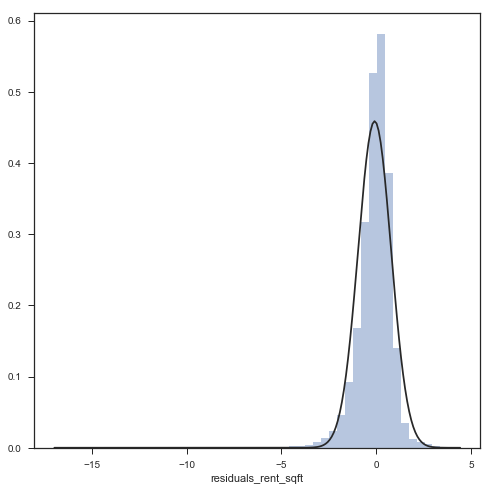

In [23]:
from scipy.stats import norm
plt.rcParams['figure.figsize']=8,8
#plot(residuals.mean(),0, residuals.mean(), 2.25)
sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(rentals.residuals_rent_sqft, fit=norm, kde=False)

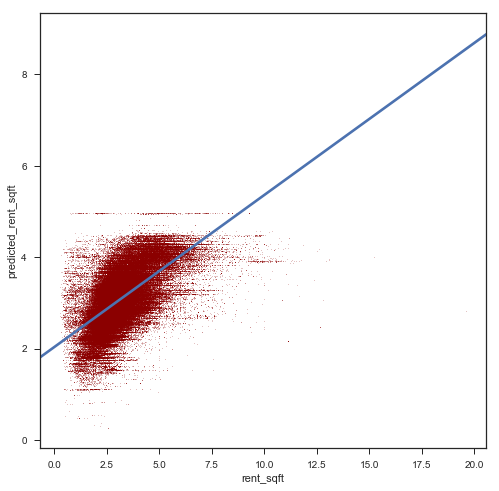

In [24]:
ax = sns.regplot(y = rentals.predicted_rent_sqft, x = rentals.rent_sqft, \
                 scatter_kws={"color":"darkred","alpha":0.3,"s":1}\
               )

In [18]:
from pyproj import Proj, transform

# WGS 84
inProj = Proj(init='epsg:4326')

# Web mercator 
outProj = Proj(init='epsg:3857')

rentals['X'],rentals['Y'] = transform(inProj,outProj,rentals['longitude'].values,rentals['latitude'].values)
rentals[['X','Y']].head()

X             Y
pid                                   
5873885791 -1.357679e+07  4.630033e+06
5873796738 -1.358320e+07  4.616557e+06
5873897352 -1.356852e+07  4.538322e+06
5873905471 -1.362595e+07  4.546905e+06
5873905300 -1.357652e+07  4.494710e+06

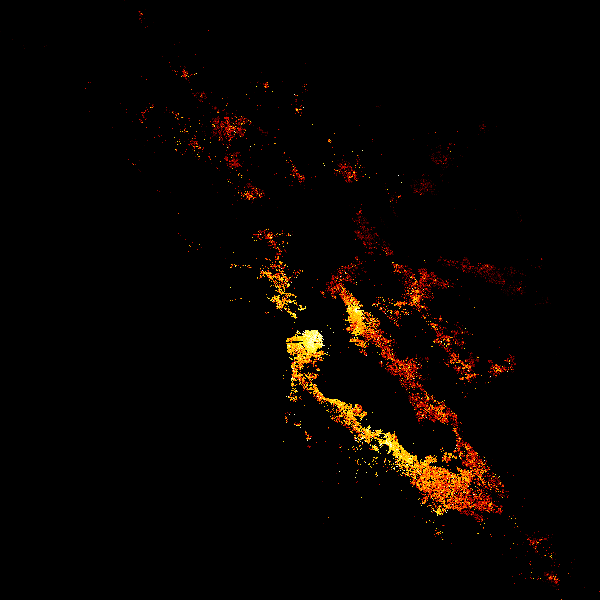

In [19]:
import datashader.transfer_functions as tf
from colorcet import fire
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(rentals, 'X', 'Y', ds.mean('rent_sqft'))
img= tf.set_background(tf.shade(agg, cmap=fire),"black")
img

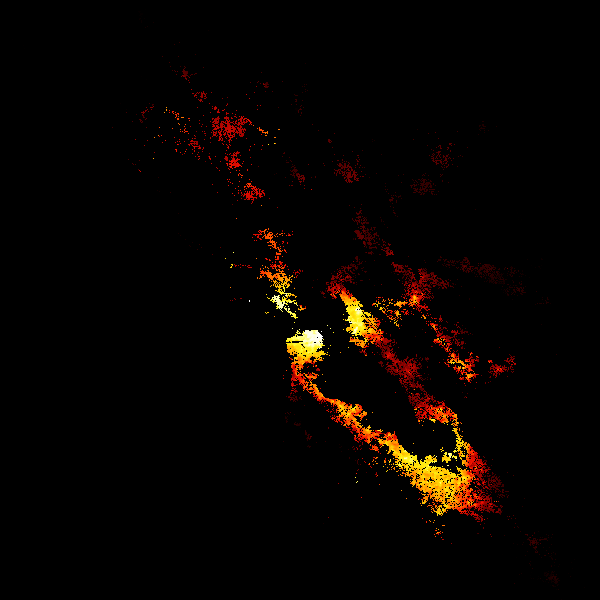

In [20]:
import datashader.transfer_functions as tf
from colorcet import fire
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(rentals, 'X', 'Y', ds.mean('predicted_rent_sqft'))
img= tf.set_background(tf.shade(agg, cmap=fire),"black")
img

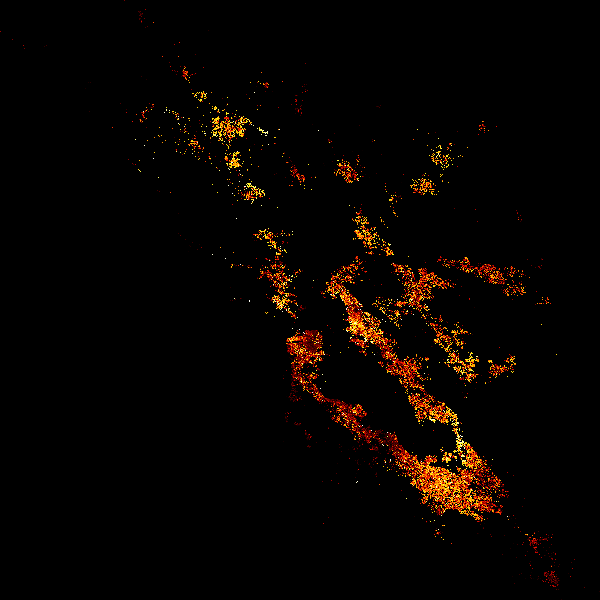

In [21]:
import datashader.transfer_functions as tf
from colorcet import fire
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(rentals, 'X', 'Y', ds.mean('residuals_rent_sqft'))
img= tf.set_background(tf.shade(agg, cmap=fire),"black")
img

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
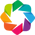

:DynamicMap   []
   :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .RGB.I  :RGB   [X,Y]   (R,G,B,A)

In [25]:
import holoviews.operation.datashader as hd
from datashader.colors import viridis

hd.shade.cmap = fire
hv.extension('bokeh', width=95)
viridis_r = list(reversed(viridis))[:-2]


url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'
#url="http://tile.stamen.com/toner-background/{Z}/{X}/{Y}.png"

tile_opts  = dict(width=600,height=600,xaxis=None,yaxis=None,bgcolor='white',show_grid=False)
map_tiles  = gv.WMTS(url).opts(style=dict(alpha=0.5), plot=tile_opts)

points     = hv.Scatter(rentals, ['X','Y'],['rent_sqft'])

nodes = hd.datashade(points,  aggregator=ds.mean('rent_sqft'),
                               width=1000, height=600)

map_tiles * nodes

In [26]:
mm.initialize()

Loading model step 'hedonic_price_sqft_single_family'
Loading model step 'hedonic_price_sqft_multi_family'


In [27]:
m.register()

Saving 'hedonic_rent_sqft.yaml': /Users/Paul/src/urbansim_parcel_bayarea/configs
Loading model step 'hedonic_rent_sqft'


In [28]:
orca.list_steps()

['test_manual_registration',
 'initialize_network_small',
 'initialize_network_walk',
 'network_aggregations_drive',
 'network_aggregations_small',
 'network_aggregations_walk',
 'hedonic_rent_sqft',
 'hedonic_price_sqft_single_family',
 'hedonic_price_sqft_multi_family']

In [ ]:
m_rent = OLSRegressionStep()
m_rent.tables = ['rentals', 'nodessmall', 'nodeswalk']
m_rent.model_expression = 'np.log1p(rent) ~ + np.log(sqft) + C(bedrooms) + np.log(units_500_walk + 1) +\
    np.log(jobs_500_walk + 1) + np.log(jobs_1500_walk+1) + np.log(jobs_10000+1) + np.log(jobs_25000) + \
    np.log(pop_10000+1) + np.log(pop_black_10000+1) + np.log(pop_hisp_10000+1) + \
    np.log(pop_asian_10000+1)'
m_rent.fit()

In [ ]:
rentals['predicted_ln_rent'] = 0.0
m_rent.out_column = 'predicted_ln_rent'
m_rent.run()
rentals = orca.get_table('rentals').to_frame()
rentals['predicted_rent'] = np.exp(rentals.predicted_ln_rent)
rentals['residuals_rent'] = rentals.predicted_rent - rentals.rent

In [ ]:
rentals.head()

In [ ]:
rentals[['rent','predicted_rent', 'residuals_rent']].describe()

In [ ]:
sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(rentals.residuals_rent, fit=norm, kde=False)

In [ ]:
ax = sns.regplot(y = rentals.predicted_rent, x = rentals.rent, \
                 scatter_kws={"color":"darkred","alpha":0.3,"s":1}\
               )

### If we like it, register it as an Orca step

In [ ]:
model.register()

In [ ]:
orca.list_steps()

### Run the Orca step

In [ ]:
orca.run(['RegressionStep-20180214-210159'])

### Check the fitted values

In [ ]:
df = orca.get_table('buildings').to_frame(['res_price_per_sqft', 'fitted_price'])
df.loc[df.fitted_price > 0].describe()

### BONUS

Running "model.register()" also registered the step with the new ModelManager extention, which saves it to disk so that it can be automatically re-loaded in the future.

The "test" model steps here were estimated earlier and loaded from disk. They're fully functional: we can run them in Orca, inspect the estimation results, etc.

In [ ]:
mm.list_steps()

In [ ]:
rs = mm.get_step('test-1')
type(rs)

In [ ]:
rs.model_expression

In [ ]:
rs.model.report_fit()